In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from torch import Tensor
from torch.autograd import Variable

In [50]:
mu = Variable(Tensor([0.]))
sigma = Variable(Tensor([1.23]))
get_w = lambda: dist.normal(mu, sigma).data[0]
get_b = lambda: dist.normal(mu, sigma).data[0]

In [40]:
x = np.linspace(-10, 10, 200)
Y = []
for _ in range(100):
    w, b = get_w(), get_b()
    y = w*x + b
    Y.append(y)

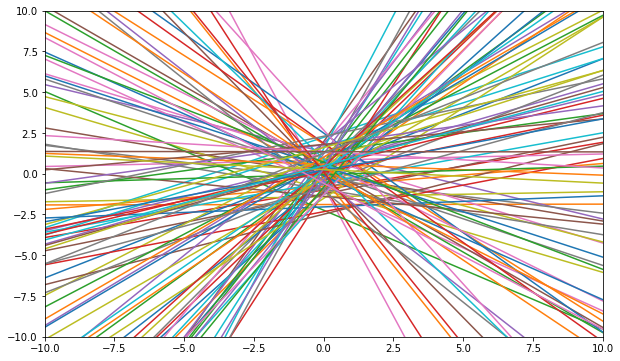

In [41]:
plt.figure(figsize=(10, 6))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
for y in Y:
    plt.plot(x, y)

In [42]:
import numpy as np

# ! i think this works?

# Define mean, covariance matrix, and no. of samples required
mean = np.array([1, 2, 3])
cov = np.diag([1, 2, 3])
Ndraws = 1000

# Do factorisation (can store this and use it again later)
L = np.linalg.cholesky(cov)

# Get 3*Ndraws Gaussian random variables (mean=0, variance=1)
norm = np.random.normal(size=Ndraws*3).reshape(3, Ndraws)

# Construct final set of random numbers (with correct mean)
rand = mean + np.dot(L, norm).T

In [43]:
# tau = np.array([1.23, 2.34])
# omega = np.array([[1, .8], [.8, 1]])
cov = np.array([[3, 4], [1, 5]])
L = np.linalg.cholesky(cov)
mu = np.array([[0., 0.]])

In [44]:
mu + (L @ np.random.randn(2, 1)).T

array([[-0.56190459,  0.09094555]])

In [45]:
get_w_and_b = lambda: mu + np.diag(tau) * np.linalg.cholesky(omega) * np.random.randn()

# Define some crazy function

In [46]:
y_true = np.sin(x)**2 - np.abs(x - 3) + 7
noisy_y_true = y_true + .5 * np.random.randn(len(y_true))

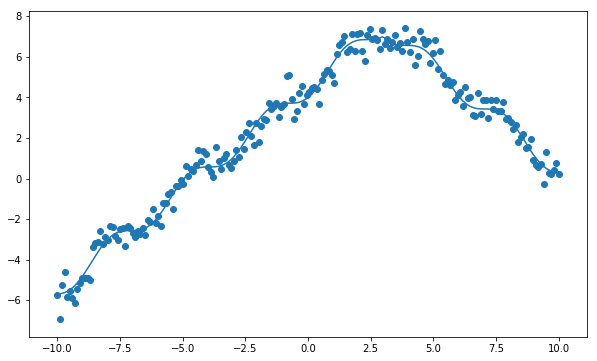

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(x, y_true)
plt.scatter(x, noisy_y_true)

In [61]:
arr = np.random.randn(200, 2)

In [145]:
D = 100
sigma = np.eye(D)

def featurize(x):
    return np.array([np.exp(-.5 * (x - d + 5)**2) for d in range(D)]).T


def mean_func(params, features):
#     return features @ params
    # given the following, the `params` arg is kinda pointless...
    return np.zeros(features.shape[0])  # the mean is given by x.dot(mu), where mu=0 is the mean of the weights prior...


def cov_kernel(first, second, sigma):
    return first @ sigma @ second.T

In [143]:
params = np.random.multivariate_normal(np.zeros(D), cov=sigma)
features = featurize(x)

mean = mean_func(params, features)
kernel = cov_kernel(features, features, sigma)

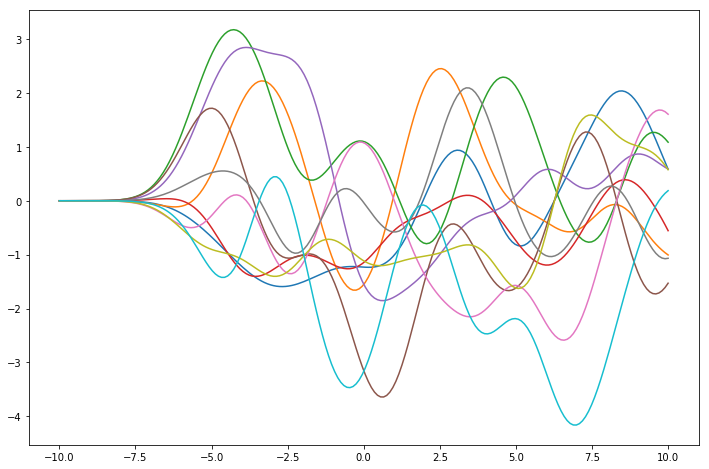

In [144]:
plt.figure(figsize=(12, 8))

for c in range(10):
    color = f'C{c}'
    ys = np.random.multivariate_normal(mean, cov_matrix)
    plt.plot(x, ys, color=color)
plt.show(p)

In [147]:
# Posterior over function evaluations for new data

x_new = np.random.randn(17)
features_new = featurize(x_new)

mean_post = mean_func(params, features_new)
A = cov_kernel(features_new, features, sigma)
B = cov_kernel(features_new, features_new, sigma)
C = cov_kernel(features, features, sigma)
# mean_post += A.dot

In [148]:
A.shape

(17, 200)

In [149]:
B.shape

(17, 17)

In [150]:
C.shape

(200, 200)

In [151]:
A @ np.linalg.inv(B + C)

ValueError: operands could not be broadcast together with shapes (17,17) (200,200) 

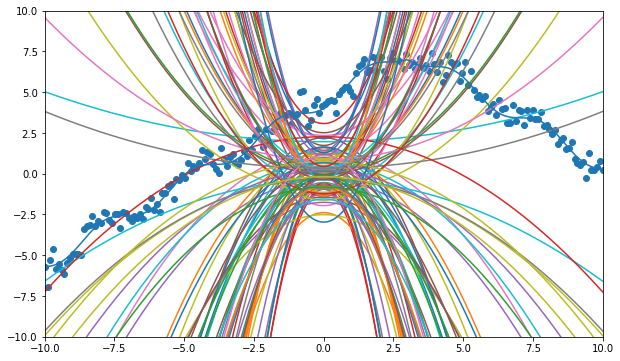

In [52]:
plt.figure(figsize=(10, 6))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
for y in Y:
    plt.plot(x, y)
plt.plot(x, y_true)
plt.scatter(x, noisy_y_true)

In [14]:
# import pandas as pd

# df = pd.DataFrame({'noisy_y_true': noisy_y_true}, index=x)

data = {xx: yy for xx, yy in zip(x, noisy_y_true)}

In [15]:
# rbf kernel
def rbf(point, neighbor, sigma=.5):
    return np.exp(-(point - neighbor)**2 / (2 * sigma**2))


def query(point, data=data, kernel=rbf):
    weighted_sum = 0
    total_weight = 0
    for x, y in data.items():
        if x != point:
            weight = kernel(point=point, neighbor=x)
            weighted_sum += weight * y
            total_weight += weight
    return weighted_sum / total_weight

In [16]:
y_approx = [query(xx) for xx in x]

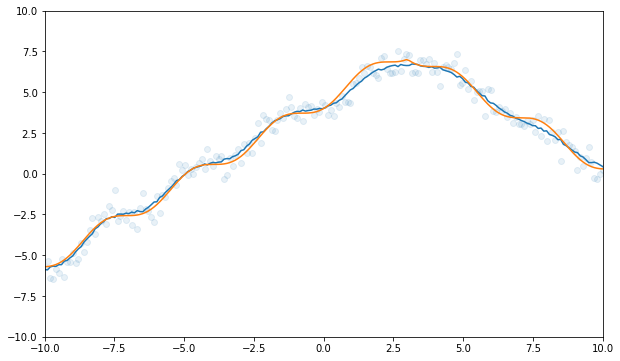

In [17]:
plt.figure(figsize=(10, 6))
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.plot(x, y_approx)
plt.plot(x, y_true)
plt.scatter(x, noisy_y_true, alpha=.1)

In [18]:
# projections = np.array([x, np.sin(x), np.cos(x), np.tanh(x)]).T
projections = np.array([x, np.abs(x-2), np.abs(x-5), x-20]).T

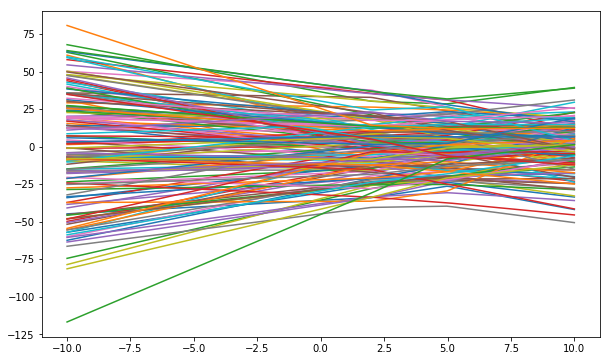

In [19]:
plt.figure(figsize=(10, 6))
# plt.ylim(0, 10)
# plt.xlim(0, 10)
for _ in range(145):
    y = projections @ np.random.randn(4)
    plt.plot(x, y)

In [9]:
# Mean function

n_features = 10
evl = 7  # number of data points at which i want to evaluate

x_new = np.random.randn(evl, n_features)
mu = np.random.randn(10)  # mean of the weights prior

mean_func_eval = x_new @ mu  # the thing we put into the posterior over function evaluations

In [10]:
# Plot some mv-normal draws using an RBF kernel

In [94]:
# def k(xs, ys, sigma=1, l=1):
#     """Sqared Exponential kernel as above but designed to return the whole
#     covariance matrix - i.e. the pairwise covariance of the vectors xs & ys.
#     Also with two parameters which are discussed at the end."""

#     # Pairwise difference matrix.
#     dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
#     return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

# def m(x):
#     """The mean function. As discussed, we can let the mean always be zero."""
#     return np.zeros_like(x)